## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18209037500104202880
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6429081600
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 6576068942196486970
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7273971712
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 14892810541861608822
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


2021-10-07 10:09:23.230418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-07 10:09:23.382324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 10:09:23.382946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 10:09:23.387822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Construct model

In [6]:
latent_dim = 256     # Latent dimensionality of the encoding space.
batch_size = 32      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [8]:
encoder_inputs = keras.Input(shape = (None, encoder_input_data.shape[2]))
encoder = keras.layers.Bidirectional(keras.layers.GRU(latent_dim, return_state = True))
encoder_outputs, state_h1, state_h2 = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape = (None, decoder_input_data.shape[2]))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_gru = keras.layers.GRU(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state = [ state_h1 ])
decoder_dense = keras.layers.Dense(decoder_target_data.shape[2], activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

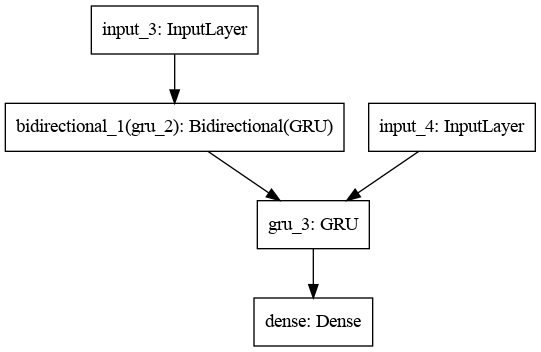

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png')

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 402432      input_3[0][0]                    
__________________________________________________________________________________________________
gru_3 (GRU)                     [(None, None, 256),  201216      input_4[0][0]                    
                                                                 bidirectional_1[0][1]        

## Train model

In [11]:
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = patience, 
                   verbose = 1, restore_best_weights = True)

log = model.fit(
    [ encoder_input_data, decoder_input_data ],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

2021-10-07 10:10:30.669666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


2021-10-07 10:10:32.881646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


110/110 [==============================] - 39s 332ms/step - loss: 1.3115 - accuracy: 0.3608 - val_loss: 1.2801 - val_accuracy: 0.3881
Epoch 2/1000
110/110 [==============================] - 36s 325ms/step - loss: 1.2369 - accuracy: 0.4262 - val_loss: 1.1786 - val_accuracy: 0.4701
Epoch 3/1000
110/110 [==============================] - 37s 332ms/step - loss: 1.1170 - accuracy: 0.5088 - val_loss: 1.0673 - val_accuracy: 0.5320
Epoch 4/1000
110/110 [==============================] - 35s 323ms/step - loss: 0.9710 - accuracy: 0.5917 - val_loss: 0.8600 - val_accuracy: 0.6534
Epoch 5/1000
110/110 [==============================] - 34s 312ms/step - loss: 0.7916 - accuracy: 0.6852 - val_loss: 0.7122 - val_accuracy: 0.7194
Epoch 6/1000
110/110 [==============================] - 34s 310ms/step - loss: 0.6001 - accuracy: 0.7772 - val_loss: 0.5424 - val_accuracy: 0.7987
Epoch 7/1000
110/110 [==============================] - 34s 311ms/step - loss: 0.4147 - accuracy: 0.8636 - val_loss: 0.3372 - val_a

110/110 [==============================] - 35s 319ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0078 - val_accuracy: 0.9984
Epoch 57/1000
110/110 [==============================] - 34s 314ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0068 - val_accuracy: 0.9990
Epoch 58/1000
110/110 [==============================] - 35s 318ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 59/1000
110/110 [==============================] - 35s 314ms/step - loss: 0.0079 - accuracy: 0.9985 - val_loss: 0.0062 - val_accuracy: 0.9990
Epoch 60/1000
110/110 [==============================] - 34s 314ms/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.0064 - val_accuracy: 0.9990
Epoch 61/1000
110/110 [==============================] - 34s 311ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0132 - val_accuracy: 0.9961
Epoch 62/1000
110/110 [==============================] - 34s 313ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0067 -

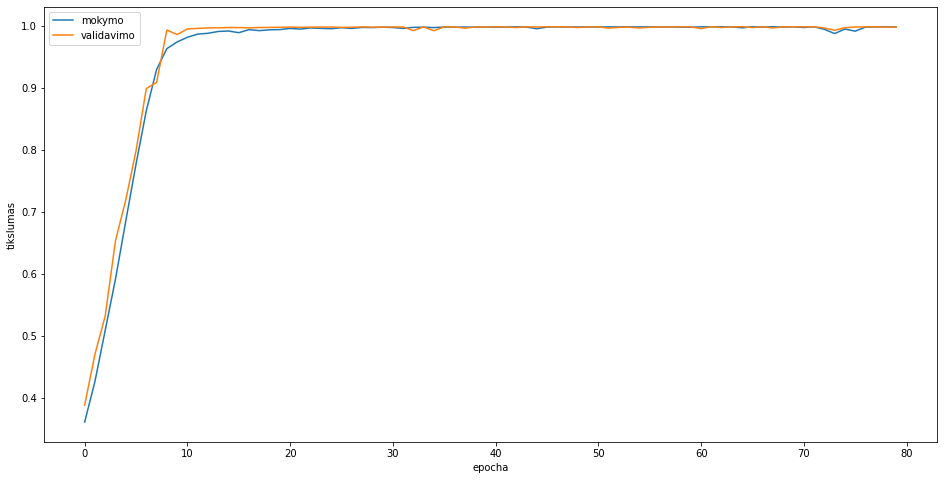

In [12]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

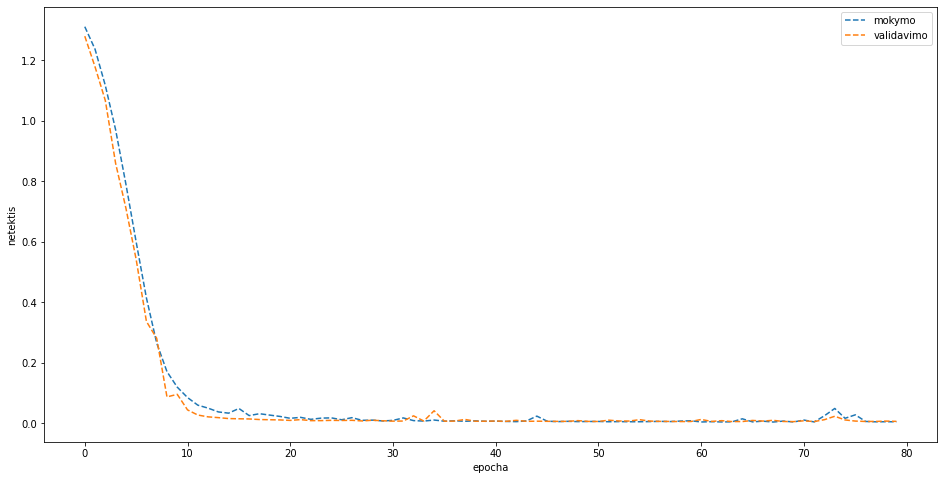

In [13]:
plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
model.save("data/ncbi_02/model_gru_bi_256")

2021-10-07 10:59:42.345759: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets
